# Algorithm Benchmarks

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats          import pearsonr
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC

In [3]:
#sourced from sklearn documentation
def correlation(dataset, threshold):
    col_corr = set() # Set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [4]:
os.getcwd()

'C:\\Users\\dkestenbaum\\Desktop\\SML Individual Project'

## Credit Card Default Data

* cust_id (numeric)
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
* default.payment.next.month: binary variable, default payment (Yes = 1, No = 0)

## Linear Regression Benchmark

Here I will implement `statmodles`' linear regression model to predict `LIMIT_BAL`.

In [5]:
#read the data
train_df = pd.read_csv('credit_default_train.csv')

In [6]:
train_df.head()

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,18895,70000.0,1.0,3.0,2.0,34.0,0.0,0.0,0.0,0.0,...,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0
1,25102,390000.0,2.0,2.0,2.0,26.0,2.0,2.0,2.0,0.0,...,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,0
2,28867,60000.0,1.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,...,26038.0,28607.0,27997.0,1378.0,1406.0,3000.0,3000.0,0.0,923.0,1
3,1842,140000.0,2.0,2.0,1.0,55.0,0.0,0.0,0.0,0.0,...,72391.0,61298.0,62193.0,4200.0,2822.0,2336.0,2588.0,2250.0,2491.0,0
4,3371,50000.0,1.0,1.0,2.0,29.0,2.0,2.0,2.0,0.0,...,1047.0,0.0,0.0,3000.0,0.0,1000.0,0.0,0.0,0.0,1


In [7]:
#fill nas with 0 for now
train_df.fillna(value=0,axis=0,inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cust_id                     20000 non-null  int64  
 1   LIMIT_BAL                   20000 non-null  float64
 2   SEX                         20000 non-null  float64
 3   EDUCATION                   20000 non-null  float64
 4   MARRIAGE                    20000 non-null  float64
 5   AGE                         20000 non-null  float64
 6   PAY_0                       20000 non-null  float64
 7   PAY_2                       20000 non-null  float64
 8   PAY_3                       20000 non-null  float64
 9   PAY_4                       20000 non-null  float64
 10  PAY_5                       20000 non-null  float64
 11  PAY_6                       20000 non-null  float64
 12  BILL_AMT1                   20000 non-null  float64
 13  BILL_AMT2                   200

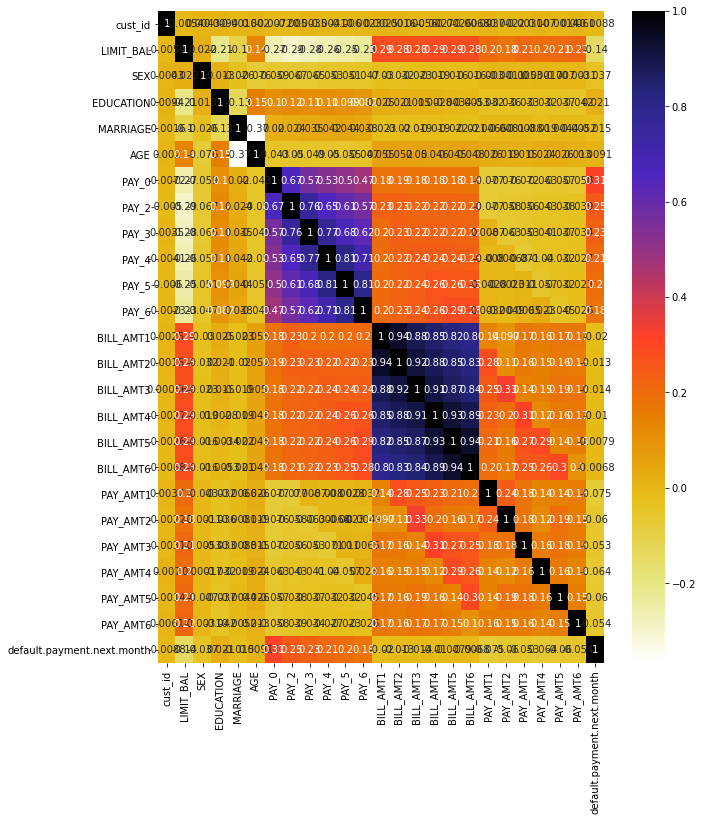

In [9]:
#check for multicollinearity
#pearson correlation matrix to explore feature correlation

plt.figure(figsize=(10,12))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [10]:
correlated_features = correlation(train_df,0.7)

In [11]:
multicollinearity = list(correlated_features)

In [12]:
#sourced from in-class notebook 

selectedFeatures = []
target = "LIMIT_BAL"

for column in train_df.columns:
    if column not in ("cust_id","LIMIT_BAL"):
        (pearson,pvalue) = pearsonr(train_df[column],train_df[target])
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)

SEX - p-vlue = 0.0015789907728467624 - selected : 0
EDUCATION - p-vlue = 5.832335647681675e-193 - selected : 1
MARRIAGE - p-vlue = 4.647943328876457e-50 - selected : 1
AGE - p-vlue = 5.644540928425171e-88 - selected : 1
PAY_0 - p-vlue = 5.0269e-319 - selected : 1
PAY_2 - p-vlue = 0.0 - selected : 1
PAY_3 - p-vlue = 0.0 - selected : 1
PAY_4 - p-vlue = 5.708004629e-314 - selected : 1
PAY_5 - p-vlue = 5.291488635713214e-274 - selected : 1
PAY_6 - p-vlue = 3.758470135061147e-238 - selected : 1
BILL_AMT1 - p-vlue = 0.0 - selected : 1
BILL_AMT2 - p-vlue = 0.0 - selected : 1
BILL_AMT3 - p-vlue = 0.0 - selected : 1
BILL_AMT4 - p-vlue = 0.0 - selected : 1
BILL_AMT5 - p-vlue = 0.0 - selected : 1
BILL_AMT6 - p-vlue = 0.0 - selected : 1
PAY_AMT1 - p-vlue = 2.0664999426514894e-178 - selected : 1
PAY_AMT2 - p-vlue = 1.0036937171964455e-141 - selected : 1
PAY_AMT3 - p-vlue = 1.6315375134862573e-203 - selected : 1
PAY_AMT4 - p-vlue = 2.38346195440641e-174 - selected : 1
PAY_AMT5 - p-vlue = 3.518587546

In [13]:
#subset for only statistically significant features
X = train_df[selectedFeatures]
#add id
X['cust_id'] = train_df["cust_id"]

#create response vector 
y = train_df[['LIMIT_BAL']]

C:\Users\DKESTE~1\AppData\Local\Temp/ipykernel_18260/711861952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cust_id'] = train_df["cust_id"]


In [14]:
#drop correlated features
X.drop(columns=multicollinearity,axis=1,inplace=True)

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
X = sm.add_constant(X)
y = np.squeeze(np.asarray(y))

In [16]:
model = OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     696.5
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:42:43   Log-Likelihood:            -2.5990e+05
No. Observations:               20000   AIC:                         5.198e+05
Df Residuals:                   19985   BIC:                         5.199e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        1.58e+05   4888.577     32.319      0.000    1.48e+05    1.68e+05
EDUCATION                  -2.976e+04    958.455    -31.046      0.000   -3.16e+04   -2.79e+04
MARRIAGE                   -1.796e+04   1509.215    -11.900      0.000   -2.09e+04    -1.5e+04
AGE                         1313.8498     82.850     15.858      0.000    1151.457    1476.243
PAY_0                      -1.226e+04    936.214    -13.097      0.000   -1.41e+04   -1.04e+04
PAY_2                      -2.526e+04    865.968    -29.166      0.000    -2.7e+04   -2.36e+04
BILL_AMT1                      0.5079      0.011     45.700      0.000       0.486       0.530
PAY_AMT1                       0.5347      0.053     10.132      0.000       0.431       0.638
PAY_AMT2                       0.3069      0.036      8.514      0.000       0.236       0.378
PAY_AMT3                       0.5498      0.046     11.985      0.000       0.460       0.640
PAY_AMT4                       0.6218      0.051     12.162      0.000       0.522       0.722
PAY_AMT5                       0.6559      0.052     12.584      0.000       0.554       0.758
PAY_AMT6                       0.6604      0.044     15.122      0.000       0.575       0.746
default.payment.next.month -6074.4404   1929.037     -3.149      0.002   -9855.513   -2293.368
cust_id                       -0.1141      0.087     -1.314      0.189      -0.284       0.056
==============================================================================
Omnibus:                     2888.623   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4823.206
Skew:                           0.974   Prob(JB):                         0.00
Kurtosis:                       4.411   Cond. No.                     6.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model.ssr

226842404928388.38

## `Train` / `Test` Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [19]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_preds = lr.predict(X_test)

In [20]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':
y_preds})
  
print(' residual sum of squares is : '+ str(np.sum(np.square(df['Predicted'] - df['Actual']))))

 residual sum of squares is : 67958479153053.086


## Logistic Regression Benchmark

In [21]:
#seperate the features from the response variable (default.payment.next.month)
X = train_df.iloc[:,:24]
y = np.array(train_df['default.payment.next.month'])

In [22]:
#initiate sklearn's logistic regression
log_reg_mod = LogisticRegression() #class_weight = 'balanced'
for_step_select = sfs(log_reg_mod, k_features=5, forward=True, verbose=2, scoring='accuracy')

In [23]:
#fit the forward stepwise selection class to the data
for_step_select = for_step_select.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   27.8s finished

[2022-03-17 15:43:12] Features: 1/5 -- score: 0.8170999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   36.0s finished

[2022-03-17 15:43:48] Features: 2/5 -- score: 0.8149[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   42.6s finished

[2022-03-17 15:44:30] Features: 3/5 -- score: 0.8126999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 |

In [24]:
best_feats = list(for_step_select.k_feature_names_)
print(best_feats)

['EDUCATION', 'PAY_0', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT6']


* Below attempting to stratify y resulted in an error.

In [25]:
#subset X for best features from forward stepwise selection only
X = X[best_feats]

In [26]:
sum(y)

4414

In [27]:
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [28]:
sum(y_test)

1339

In [29]:
log_reg_mod.fit(X_train,y_train)

y_preds = log_reg_mod.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.6042634614943987

# Decision Tree Classifier

In [30]:
clf = DecisionTreeClassifier(random_state=0)

cv_clf = cross_val_score(clf, X_train, y_train, cv=10)

In [31]:
cv_clf

array([0.72785714, 0.75357143, 0.72785714, 0.73285714, 0.73214286,
       0.70571429, 0.73357143, 0.71642857, 0.71428571, 0.72428571])

In [32]:
clf.fit(X_train,y_train)

y_preds = clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.5883753434301986

# Random Forest Classifier

In [31]:
rf_clf = RandomForestClassifier(n_estimators=100,random_state=123)

rf_clf.fit(X_train,y_train)

y_preds = rf_clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.6221489905831988

# SVM

In [ ]:
SVM_clf = SVC(kernel='linear') #using linear kernel
#fit
SVM_clf.fit(X_train, y_train)
#predict
y_preds = SVM_clf.predict(X_test)

In [ ]:
#eval
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)